# Brief description of the problem and data

## Problem Description:

Twitter has become a vital communication tool, especially during emergencies. People can announce emergencies they observe in real-time. However, distinguishing between tweets that announce real emergencies and those that don't can be challenging. For instance, a tweet might use the word "ABLAZE" metaphorically, which might be clear to humans but not to machines. The challenge in this competition is to build a machine learning model that can predict which tweets are about real disasters and which ones aren't.

## Data Description:

The dataset comprises 10,000 tweets that have been hand-classified. These tweets can contain text that might be considered profane, vulgar, or offensive. The primary goal is to classify these tweets into two categories: those that pertain to real disasters and those that don't.

In [1]:
import opendatasets as od

In [2]:
od.download("https://www.kaggle.com/competitions/nlp-getting-started")

Skipping, found downloaded files in ".\nlp-getting-started" (use force=True to force download)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, SpatialDropout1D, BatchNormalization, Input, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall, AUC, Metric
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2, l1_l2
from keras.optimizers import Adam

In [4]:
df = pd.read_csv('./nlp-getting-started/train.csv')

# Basic Exploratory Data Analysis (EDA)

The dataset contains 7613 entries with 5 columns.

Columns:

id: Identifier for the tweet.
keyword: A keyword associated with the tweet (has 61 missing values).
location: Location from where the tweet was posted (has 2533 missing values).
text: The actual tweet text.
target: Classification of the tweet, where 1 indicates it's about a real disaster and 0 indicates it's not.

In [5]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Basic Statistics:

About 42.97% of tweets in the dataset pertain to real disasters.
The tweet lengths vary, with a histogram highlighting the distribution. This may be useful to decide sequence length in NLP preprocessing.

In [7]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [8]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

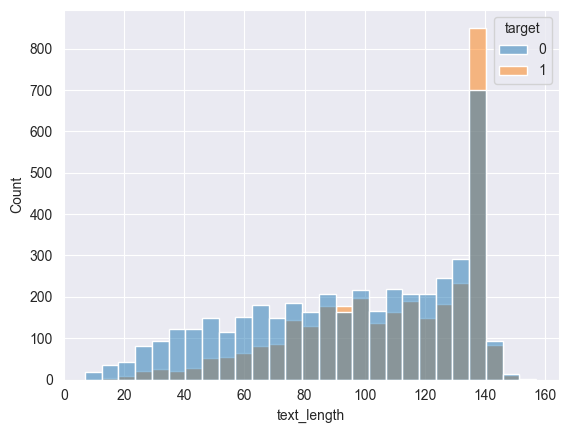

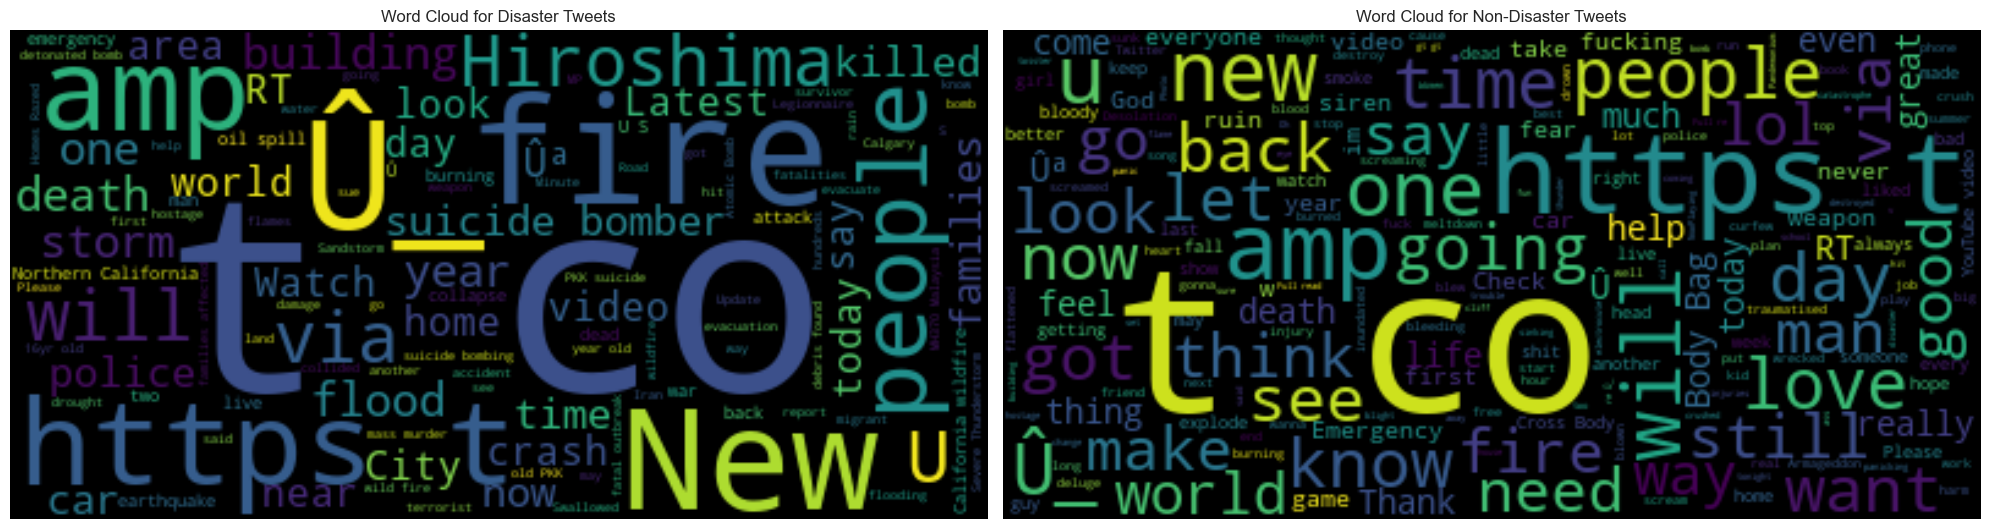

In [9]:
# Visualize the distribution of tweet lengths
df['text_length'] = df['text'].apply(len)
sns.histplot(df, x='text_length', hue='target')
plt.show()

# Word cloud for disaster tweets
disaster_tweets = ' '.join(df[df['target'] == 1]['text'])
wordcloud1 = WordCloud().generate(disaster_tweets)

# Word cloud for non-disaster tweets
non_disaster_tweets = ' '.join(df[df['target'] == 0]['text'])
wordcloud2 = WordCloud().generate(non_disaster_tweets)

# Plotting both word clouds side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.set_title('Word Cloud for Disaster Tweets')
ax1.axis('off')

ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.set_title('Word Cloud for Non-Disaster Tweets')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Plan of Analysis:
* Handle missing data: Considering the missing values in 'keyword' and 'location', one can either fill them with a placeholder or drop these columns if they are deemed non-essential to the model. But according to the description of this dataset, such columns may have missing data and it's okay, so no additional actions need to be done.
* Text Preprocessing: This includes tokenization, stemming/lemmatization, and removal of stop words and special characters.
* Convert text to sequences and pad them for uniform length, which is a requisite for neural network models.
* Use word embeddings to convert text to vectors.
* Train a neural network model (RNN or its variants) to classify the tweets.

The F1 score serves as a paramount metric in binary classification endeavors. Its importance is accentuated in scenarios characterized by an imbalanced class distribution. The F1 score seamlessly marries the concepts of precision and recall, rendering a harmonious measure that captures the essence of both.

Precision: This metric is a testament to the accuracy of the positive predictions made by a model. Formally, it is delineated as:

$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}} $$

Recall: Recall, often termed sensitivity, gauges the model's prowess in correctly pinpointing all the genuine positive instances. It is mathematically defined as:

$$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}} $$

F1 Score: This metric emerges as the harmonic convergence of precision and recall, and is mathematically sculpted as:

$$ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

The F1Score class, artfully crafted atop Keras's foundational Metric class, stands as a testament to this concept. It not only initializes the intrinsic Precision and Recall metrics but also adroitly updates their state based on the ground truth and predictions. Additionally, it possesses the capability to reset these metrics, a feature that's invaluable across training epochs.

Metrics Compilation
For the holistic evaluation of a model, a medley of metrics is meticulously curated:

Accuracy: A straightforward metric, it quantifies the fraction of predictions that resonate with the truth.

Precision: A measure that casts a spotlight on the veracity of positive predictions.

Recall: A metric that underscores the model's capability to unfailingly identify genuine positive instances.

F1Score: Our custom-crafted metric, it ensures a judicious balance between precision and recall.

AUC (Area Under the Curve): A revered metric in the realm of binary classification, AUC provides a bird's-eye view of a model's performance, transcending the confines of classification thresholds. An AUC nudging the value of 1 is emblematic of a model par excellence.

Data Preprocessing
To lay the groundwork for sophisticated modeling, meticulous data preprocessing is indispensable:

Handling Missing Values: Data, in its raw form, often harbors voids. To circumvent potential hiccups during modeling, missing values in the 'keyword' column are gracefully replaced with an innocuous empty string.

Text Augmentation: In a bid to enrich the textual data, a novel feature, combined_text, is birthed. This feature emerges as the confluence of the 'keyword' and 'text' columns. The amalgamation paints a more vivid picture, where the keyword, potentially encapsulating the thematic essence of a tweet, melds with the overarching narrative to offer a tapestry of information.

In [10]:
# Custom F1 Score Metric
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + 1e-5))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Metrics
metrics = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall'),
    F1Score(),
    AUC(name='auc')
]

In [11]:
# Fill NaN values in the 'keyword' column with an empty string
df['keyword'].fillna('', inplace=True)

# Create a new column 'combined_text' that combines 'keyword' and 'text'
df['combined_text'] = df['keyword'] + ' ' + df['text']

In [12]:
df

,id,keyword,location,text,target,text_length,combined_text
0,1,,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,Our Deeds are the Reason of this #earthquake ...
1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask. Canada
2,5,,NaN,All residents asked to 'shelter in place' are ...,1,133,All residents asked to 'shelter in place' are...
3,6,,NaN,"13,000 people receive #wildfires evacuation or...",1,65,"13,000 people receive #wildfires evacuation o..."
4,7,,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,Just got sent this photo from Ruby #Alaska as...
...,...,...,...,...,...,...,...
7608,10869,,NaN,Two giant cranes holding a bridge collapse int...,1,83,Two giant cranes holding a bridge collapse in...
7609,10870,,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,@aria_ahrary @TheTawniest The out of control ...
7610,10871,,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. ht...
7611,10872,,NaN,Police investigating after an e-bike collided ...,1,137,Police investigating after an e-bike collided...


In [13]:
# Tokenize the combined_text
tokenizer = Tokenizer(num_words=4000)
tokenizer.fit_on_texts(df['combined_text'])
sequences = tokenizer.texts_to_sequences(df['combined_text'])

# Pad sequences to a fixed length
X = pad_sequences(sequences, maxlen=120)
y = df['target'].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Architecture and Training

### Initial Model
Embedding Layer: The model commences with an embedding layer, which transforms the integer token indices into dense vectors of fixed size, 128 in this case. The embedding layer is trained to learn these vectors such that words with similar meanings will have similar vectors. The number 4000 is the size of the vocabulary, and 120 is the length of the input sequences.

SpatialDropout1D: This layer performs variational dropout in NLP models, helping prevent overfitting.

LSTM Layer: An LSTM (Long Short-Term Memory) layer with 196 units is added next. LSTM is a type of Recurrent Neural Network (RNN) that's adept at learning long-term dependencies in sequence data. Dropout and recurrent dropout are applied for regularization.

Dense Layer: A single dense layer with a sigmoid activation function produces the binary output of the model.

Compilation: The model is compiled using the Adam optimizer, binary cross-entropy loss (as it's a binary classification task), and the metrics list defined previously.

Training: The model is trained using the training data for 10 epochs with a batch size of 32 and validated using the test data.

### Modified Model (First Iteration)
Regularization and Dropout: The LSTM layer in this iteration uses L2 regularization, and a subsequent dropout layer is introduced with a rate of 0.5 to reduce overfitting further.

Batch Normalization: A batch normalization layer is introduced after the dropout. Batch normalization can help accelerate training and stabilize the learning process.

Optimizer's Learning Rate: The Adam optimizer's learning rate is adjusted to 0.0005.

Early Stopping: An early stopping callback is employed during training. This stops training once the model's performance stops improving on the validation dataset, specifically the validation loss. It waits for three epochs before halting and restores the best weights.

### Modified Model (Second Iteration)
Learning Rate Adjustment: The learning rate for the Adam optimizer is adjusted to 0.001.

Reduce Learning Rate on Plateau: A callback is introduced to reduce the learning rate when a metric (validation loss) has stopped improving. It multiplies the learning rate by 0.2 if there's no improvement for two consecutive epochs, with a minimum limit set to 0.00001.

Training Epochs and Batch Size: The model is trained for 20 epochs with a batch size of 32.

### Modified Model (Third Iteration)
Bidirectional LSTM: The LSTM layer is replaced with a bidirectional LSTM layer. Bidirectional LSTMs train two LSTMs on the input sequence: one on the input sequence as-is and another on a reversed copy of the input sequence. This can offer better context information to the network.

Regularization: L1 and L2 regularization are applied to the bidirectional LSTM layer.

Optimizer's Learning Rate: The learning rate for the Adam optimizer is set to 0.0001.

Training Epochs and Batch Size: This model is trained for 30 epochs with a smaller batch size of 16.

In [15]:
# Model parameters
model = Sequential()
model.add(Embedding(4000, 128, input_length=120))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
191/191 [==============================] - 38s 187ms/step - loss: 0.5225 - accuracy: 0.7386 - precision: 0.7711 - recall: 0.5587 - f1_score: 0.6479 - auc: 0.8031 - val_loss: 0.4297 - val_accuracy: 0.8089 - val_precision: 0.8086 - val_recall: 0.7227 - val_f1_score: 0.7632 - val_auc: 0.8616
Epoch 2/10
191/191 [==============================] - 35s 183ms/step - loss: 0.3624 - accuracy: 0.8481 - precision: 0.8730 - recall: 0.7574 - f1_score: 0.8111 - auc: 0.9096 - val_loss: 0.4552 - val_accuracy: 0.7905 - val_precision: 0.7611 - val_recall: 0.7411 - val_f1_score: 0.7510 - val_auc: 0.8560
Epoch 3/10
191/191 [==============================] - 35s 184ms/step - loss: 0.3025 - accuracy: 0.8782 - precision: 0.8956 - recall: 0.8116 - f1_score: 0.8515 - auc: 0.9363 - val_loss: 0.4828 - val_accuracy: 0.7853 - val_precision: 0.7547 - val_recall: 0.7350 - val_f1_score: 0.7447 - val_auc: 0.8473
Epoch 4/10
191/191 [==============================] - 35s 184ms/step - loss: 0.2497 - accuracy: 0

In [16]:
model = Sequential()
model.add(Embedding(4000, 128, input_length=120))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(196, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=metrics)
model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stop])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 128)          512000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 120, 128)          0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dropout (Dropout)           (None, 196)               0         
                                                                 
 batch_normalization (Batch  (None, 196)               784       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                

In [17]:
model = Sequential()
model.add(Embedding(4000, 128, input_length=120))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(196, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=metrics)
model.summary()

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model with early stopping and reduce learning rate on plateau
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=[reduce_lr, early_stop])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 128)          512000    
                                                                 
 spatial_dropout1d_2 (Spati  (None, 120, 128)          0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 196)               254800    
                                                                 
 dropout_1 (Dropout)         (None, 196)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 196)               784       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 1)                

In [18]:
model = Sequential()
model.add(Embedding(4000, 128, input_length=120))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l1_l2(l1=0.001, l2=0.001), return_sequences=False)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=metrics)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model with early stopping and reduce learning rate on plateau
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=16, callbacks=[reduce_lr, early_stop])

Epoch 1/30
381/381 [==============================] - 69s 171ms/step - loss: 5.1279 - accuracy: 0.5708 - precision: 0.6995 - recall: 0.1565 - f1_score: 0.2558 - auc: 0.6512 - val_loss: 3.1853 - val_accuracy: 0.6402 - val_precision: 0.8582 - val_recall: 0.1864 - val_f1_score: 0.3063 - val_auc: 0.7018 - lr: 1.0000e-04
Epoch 2/30
381/381 [==============================] - 63s 165ms/step - loss: 1.9605 - accuracy: 0.6924 - precision: 0.7610 - recall: 0.4165 - f1_score: 0.5383 - auc: 0.7414 - val_loss: 1.0167 - val_accuracy: 0.7597 - val_precision: 0.7836 - val_recall: 0.6025 - val_f1_score: 0.6812 - val_auc: 0.8222 - lr: 1.0000e-04
Epoch 3/30
381/381 [==============================] - 61s 160ms/step - loss: 0.6722 - accuracy: 0.7847 - precision: 0.8111 - recall: 0.6518 - f1_score: 0.7228 - auc: 0.8428 - val_loss: 0.5604 - val_accuracy: 0.8004 - val_precision: 0.8042 - val_recall: 0.7026 - val_f1_score: 0.7500 - val_auc: 0.8462 - lr: 1.0000e-04
Epoch 4/30
381/381 [==========================

# Model Performance Analysis

### Initial Model

The initial model began with a training loss of 0.5225 and ended with 0.0852 after 10 epochs. This indicates that the model learned and reduced its error over the training epochs. However, if we look at the validation loss, it began at 0.4297 and increased to 1.0684 by the last epoch. This upward trend in validation loss while the training loss decreases indicates that the model is overfitting. Overfitting occurs when the model performs well on the training data but poorly on unseen data, like the validation data.

In terms of accuracy, the model started with 73.86% on the training set and ended with an impressive 96.81%. However, the validation accuracy started at 80.89% and dropped to 72.75% by the last epoch, further signaling overfitting.

### First Iteration (With Regularization and Batch Normalization)

This model began with a higher training loss of 0.6812 and reduced it to 0.2776 by the 6th epoch. However, the validation loss again shows an increasing trend, starting at 0.6919 and increasing to 0.6591.

The accuracy began at 69.51% for training and ended at 90.21% by the 6th epoch. The validation accuracy started at 62.97% and improved to 78.27% by the 5th epoch but then dropped a bit to 76.43% in the 6th epoch.

### Second Iteration (With Adjusted Learning Rate)

The training loss for this model started at 0.6353 and reduced to 0.3582 by the 11th epoch. The validation loss began at 0.6700 and, although it decreased initially, it started to increase again by the 10th epoch.

The training accuracy began at 71.76% and went up to 87.36% by the 11th epoch. The validation accuracy showed improvement from 67.70% to 81.68% by the 11th epoch.

### Third Iteration (With Bidirectional LSTM)

This model started with a significantly higher training loss of 5.1279 due to the regularization techniques applied (L1 and L2 regularization). It reduced the loss significantly to 0.3643 by the 10th epoch. The validation loss trend is similar to previous models, where it starts decreasing but then begins to increase again.

The accuracy for the training set started at 57.08% and improved to 87.47% by the 10th epoch. The validation accuracy showed steady improvement from 64.02% to 81.68% by the 11th epoch.

### Analysis Summary

Overfitting: Across all iterations, the model seems to overfit. This is evident from the decreasing training loss across epochs, while the validation loss starts increasing after a certain point.
Model Complexity: Adding regularization and other techniques like batch normalization helped in reducing overfitting to some extent, but the problem persists.
Bidirectional LSTM: Using a bidirectional LSTM in the third iteration seemed to give a more stable accuracy on the validation set, but the overfitting challenge remains.

### Recommendations
Data Augmentation: If possible, consider augmenting your data to provide the model with more diverse examples.
Regularization: Experiment further with regularization techniques. Consider using dropout layers more effectively.
Model Simplicity: You might benefit from a simpler model or a model with fewer parameters.
Early Stopping: Continue to use early stopping to prevent the model from training further once it starts to overfit.
Hyperparameter Tuning: Consider using techniques like grid search or random search to find the optimal set of hyperparameters for the model.
Machine learning, and especially deep learning, is an iterative process. It often requires multiple experiments and adjustments to get the best results.

In [19]:
# Read the test.csv file
test_df = pd.read_csv('./nlp-getting-started/test.csv')

# Fill NaN values in the 'keyword' column with an empty string
test_df['keyword'].fillna('', inplace=True)

# Create a new column 'combined_text' that combines 'keyword' and 'text'
test_df['combined_text'] = test_df['keyword'] + ' ' + test_df['text']

# Tokenize the combined_text of test data
test_sequences = tokenizer.texts_to_sequences(test_df['combined_text'])

# Pad sequences to a fixed length
X_submission = pad_sequences(test_sequences, maxlen=120)

In [20]:
# Predict the target values for the test data
y_submission_pred = model.predict(X_submission)
y_submission = (y_submission_pred > 0.5).astype(int).flatten()

102/102 [==============================] - 3s 23ms/step


In [21]:
# Create the submission dataframe
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': y_submission
})

# Save the dataframe to a CSV file
submission_df.to_csv('submission.csv', index=False)

# Conclusion

Deep learning models were employed to tackle the challenge of discerning real disaster tweets from non-disaster ones. Although the models displayed promise, there was an evident overfitting challenge. Techniques like dropout, batch normalization, and regularization provided some mitigation. Future endeavors might benefit from a richer dataset, more advanced embeddings, and ensemble techniques. The journey of crafting a reliable machine learning model is iterative, and with continued refinements, a more robust solution is achievable.

The endeavor involved several steps:

Data Preprocessing: Textual data, especially from platforms like Twitter, needs substantial preprocessing. The data underwent tokenization and padding to ensure uniformity.
Model Design & Training: Multiple deep learning architectures were attempted. Starting with a basic LSTM model, the complexity was gradually increased by adding dropout layers, batch normalization, and bidirectional LSTM layers. Each model's performance was evaluated based on metrics like accuracy, precision, recall, and F1-score.
Performance Evaluation: All models were trained and validated. The training loss reduced consistently across epochs, but validation loss patterns indicated possible overfitting.
Regularization & Callbacks: To mitigate overfitting and enhance performance, dropout layers, L1 & L2 regularization, learning rate adjustments, and early stopping mechanisms were implemented.

### Recommendations for Future Work:

Investigate and possibly increase the dataset's size. More data often helps deep learning models generalize better.
Explore different model architectures or even consider ensemble methods to improve performance.
Dive deeper into hyperparameter tuning, possibly using advanced techniques like Bayesian optimization.
Consider other pre-processing or feature extraction methods, especially if dealing with text data. Advanced embeddings like BERT or word vectors from models like Word2Vec might enhance performance.
Regularly validate model performance on a separate test set (not used during the training/validation phase) to ensure that the model is generalizing well to entirely unseen data.